The goal of this notebook is to help Adventure works predict customer average monthly spend given the customer info, bike buyer and available average month spend data. This is a regression problem and we will explore various ML Regressors. We shall first perform needed data clean up and visualization, tuning, data balance and analysis.

In [1]:
# perform necessary import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math

%matplotlib inline

In [2]:
# load datasets
customer_info = pd.read_csv('data/AdvWorksCusts.csv')
customer_spending = pd.read_csv('data/AW_AveMonthSpend.csv')
customer_has_bike= pd.read_csv('data/AW_BikeBuyer.csv')

In [3]:
# remove duplicates
print(customer_info.shape)
print(customer_info.CustomerID.unique().shape)
customer_info.drop_duplicates(subset = 'CustomerID', keep = 'last', inplace = True)
print(customer_info.shape)
print(customer_info.CustomerID.unique().shape)

(16519, 23)
(16404,)
(16404, 23)
(16404,)


In [4]:
print(customer_spending.shape)
print(customer_spending.CustomerID.unique().shape)
customer_spending.drop_duplicates(subset = 'CustomerID', keep = 'last', inplace = True)
print(customer_spending.shape)
print(customer_spending.CustomerID.unique().shape)

(16519, 2)
(16404,)
(16404, 2)
(16404,)


In [5]:
print(customer_has_bike.shape)
print(customer_has_bike.CustomerID.unique().shape)
customer_has_bike.drop_duplicates(subset = 'CustomerID', keep = 'last', inplace = True)
print(customer_has_bike.shape)
print(customer_has_bike.CustomerID.unique().shape)

(16519, 2)
(16404,)
(16404, 2)
(16404,)


In [6]:
# check for missing values
(customer_has_bike.astype(np.object).isnull()).any()

CustomerID    False
BikeBuyer     False
dtype: bool

In [7]:
(customer_spending.astype(np.object).isnull()).any()

CustomerID       False
AveMonthSpend    False
dtype: bool

In [8]:
(customer_info.astype(np.object).isnull()).any()

CustomerID              False
Title                    True
FirstName               False
MiddleName               True
LastName                False
Suffix                   True
AddressLine1            False
AddressLine2             True
City                    False
StateProvinceName       False
CountryRegionName       False
PostalCode              False
PhoneNumber             False
BirthDate               False
Education               False
Occupation              False
Gender                  False
MaritalStatus           False
HomeOwnerFlag           False
NumberCarsOwned         False
NumberChildrenAtHome    False
TotalChildren           False
YearlyIncome            False
dtype: bool

Data is cleaned and fine with missing values check. Will now perform exploratory data analysis

In [9]:
customer_info.describe()

,CustomerID,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome
count,16404.000000,16404.000000,16404.000000,16404.000000,16404.000000,16404.000000
mean,20240.143136,0.674104,1.499756,0.991100,2.004511,78129.672397
std,5340.370705,0.468723,1.139135,1.514278,1.682318,39728.383493
min,11000.000000,0.000000,0.000000,0.000000,0.000000,9482.000000
25%,15617.750000,0.000000,1.000000,0.000000,0.000000,47808.750000
50%,20231.500000,1.000000,2.000000,0.000000,2.000000,76125.000000
75%,24862.250000,1.000000,2.000000,2.000000,3.000000,105211.750000
max,29482.000000,1.000000,4.000000,5.000000,5.000000,196511.000000


In [10]:
customer_spending.describe()

,CustomerID,AveMonthSpend
count,16404.000000,16404.000000
mean,20240.143136,72.391002
std,5340.370705,27.269921
min,11000.000000,22.000000
25%,15617.750000,52.000000
50%,20231.500000,68.000000
75%,24862.250000,84.000000
max,29482.000000,176.000000


In [11]:
customer_has_bike.describe()

,CustomerID,BikeBuyer
count,16404.000000,16404.000000
mean,20240.143136,0.332541
std,5340.370705,0.471138
min,11000.000000,0.000000
25%,15617.750000,0.000000
50%,20231.500000,0.000000
75%,24862.250000,1.000000
max,29482.000000,1.000000


Merge data for analysis. We will like to predict customer average monthly spend hence this is the label in question.

In [12]:
combined = customer_info
combined = customer_info.merge(customer_spending, on='CustomerID', how='left')
combined.head()

,CustomerID,Title,FirstName,MiddleName,LastName,Suffix,AddressLine1,AddressLine2,City,StateProvinceName,...,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,AveMonthSpend
0,11000,NaN,Jon,V,Yang,NaN,3761 N. 14th St,NaN,Rockhampton,Queensland,...,Bachelors,Professional,M,M,1,0,0,2,137947,89
1,11001,NaN,Eugene,L,Huang,NaN,2243 W St.,NaN,Seaford,Victoria,...,Bachelors,Professional,M,S,0,1,3,3,101141,117
2,11002,NaN,Ruben,NaN,Torres,NaN,5844 Linden Land,NaN,Hobart,Tasmania,...,Bachelors,Professional,M,M,1,1,3,3,91945,123
3,11003,NaN,Christy,NaN,Zhu,NaN,1825 Village Pl.,NaN,North Ryde,New South Wales,...,Bachelors,Professional,F,S,0,1,0,0,86688,50
4,11004,NaN,Elizabeth,NaN,Johnson,NaN,7553 Harness Circle,NaN,Wollongong,New South Wales,...,Bachelors,Professional,F,S,1,4,5,5,92771,95


In [13]:
# generate Age column since we are given birthdate
from datetime import datetime
from dateutil.parser import parse 

def generate_age(customer_info, format):
    collection_day = birthday = datetime(1998, 1, 1, 0, 0, 0)
    age = []
    for index, row in customer_info.iterrows():
        conv = datetime.strptime(row['BirthDate'], format)
        age.append(int((collection_day - conv).days/365))
    return age

In [14]:
combined['Age'] = generate_age(combined, '%Y-%m-%d')

In [15]:
combined[['BirthDate','Age']].head()

,BirthDate,Age
0,1966-04-08,31
1,1965-05-14,32
2,1965-08-12,32
3,1968-02-15,29
4,1968-08-08,29


Plotting scatter plots to see relationships between other numeric features and AveMonthSpend

In [16]:
def plot_scatter(auto_prices, cols, col_y = 'AveMonthSpend'):
    for col in cols:
        fig = plt.figure(figsize=(7,6)) # define plot area
        ax = fig.gca() # define axis   
        auto_prices.plot.scatter(x = col, y = col_y, ax = ax)
        ax.set_title('Scatter plot of ' + col_y + ' vs. ' + col) # Give the plot a main title
        ax.set_xlabel(col) # Set text for the x axis
        ax.set_ylabel(col_y)# Set text for y axis
        plt.show()

c:\users\awuah\envs\py1\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


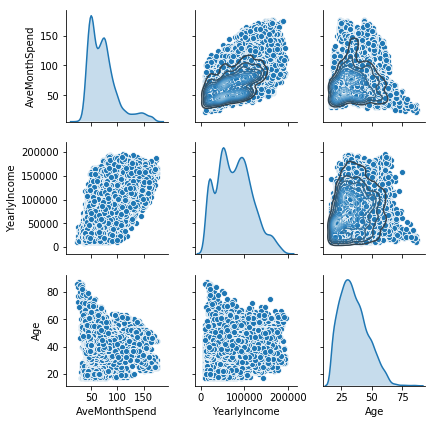

In [17]:
cols = ['AveMonthSpend','YearlyIncome','Age']
sns.pairplot(combined[cols],  palette="Set2", diag_kind="kde", size=2).map_upper(sns.kdeplot, cmap="Blues_d")

From the scatter plots for YearlyIncome and Age there is some relationship with AveMonthSpend. These might be good features.

Will make use of box plots to take a look at the categorical variables to AveMonthSpend

In [18]:
def plot_box(auto_prices, cols, col_y = 'AveMonthSpend'):
    for col in cols:
        sns.set_style("whitegrid")
        sns.boxplot(col, col_y, data=auto_prices)
        plt.xlabel(col) # Set text for the x axis
        plt.ylabel(col_y)# Set text for y axis
        plt.show()

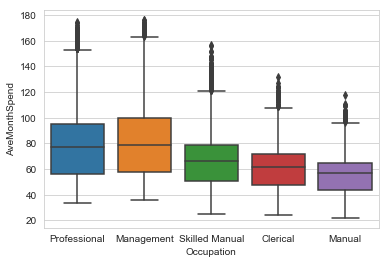

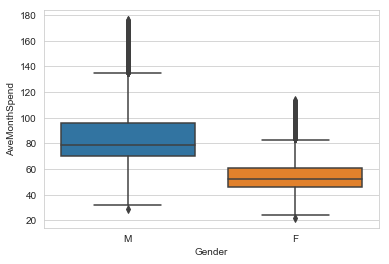

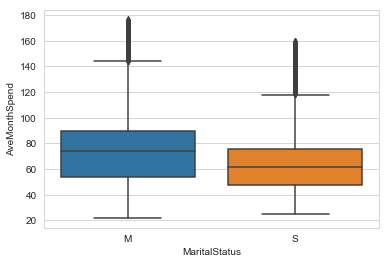

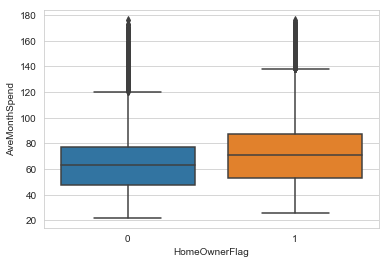

In [19]:
cols = ['Occupation', 'Gender', 'MaritalStatus', 'HomeOwnerFlag']
plot_box(combined, cols)

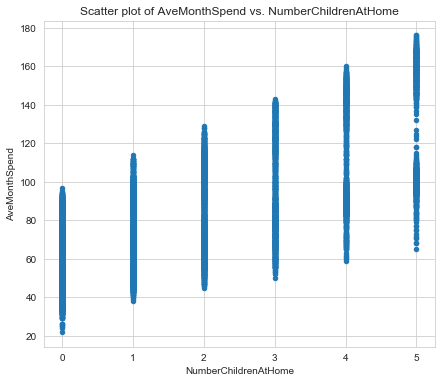

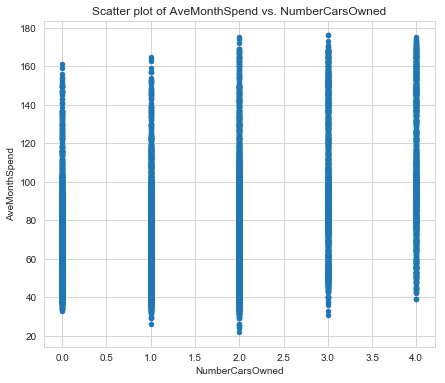

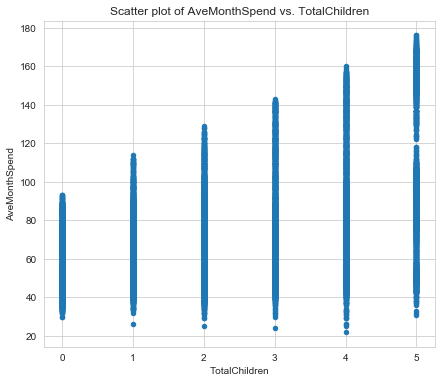

In [20]:
plot_scatter(combined, ['NumberChildrenAtHome', 'NumberCarsOwned', 'TotalChildren'])

Categorical features such as occupation, gender, marital status and home owner flag have distinct relationships with average month spend. The quartiles are of different levels. It seems that Males spend more on average than females same for married and homeowners.
Numeric features of interest would be Number of children at home, age and yearly income(as seen earlier).

In [21]:
categorical_features = ['Gender','MaritalStatus','HomeOwnerFlag', 'Occupation']
numeric_features = ['Age', 'YearlyIncome','NumberChildrenAtHome']

Now it is time to prepare the data for training.
1. We will be doing one-hot encoding for categorical variables.
2. Converting features to numpy arrays for scikit learn ML library.

In [22]:
# define encoder for categorical variables
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm

def encode_string(cat_features):
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    return encoded.transform(enc_cat_features.reshape(-1,1)).toarray()

In [23]:
def encode_cat_features(features):
    categorical_features = ['Gender','MaritalStatus','HomeOwnerFlag']
    f = encode_string(features['Occupation'])
    for cat in categorical_features:
        enc = encode_string(features[cat])
        f = np.concatenate([f,enc],1)
    return f

In [24]:
labels = np.array(combined.AveMonthSpend)
print(labels)

[ 89 117 123 ...  79  65  68]


In [25]:
selected = numeric_features + categorical_features
features = combined[selected]
features.head()

,Age,YearlyIncome,NumberChildrenAtHome,Gender,MaritalStatus,HomeOwnerFlag,Occupation
0,31,137947,0,M,M,1,Professional
1,32,101141,3,M,S,0,Professional
2,32,91945,3,M,M,1,Professional
3,29,86688,0,F,S,0,Professional
4,29,92771,5,F,S,1,Professional


In [26]:
encoded = encode_cat_features(features)
encoded[:,:]

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.]])

In [27]:
numeric_features = np.array(combined[numeric_features])
numeric_features[:,:]

array([[    31, 137947,      0],
       [    32, 101141,      3],
       [    32,  91945,      3],
       ...,
       [    58, 133053,      0],
       [    51,  31930,      0],
       [    52,  59382,      0]], dtype=int64)

In [28]:
features = np.concatenate([encoded,numeric_features], 1)
print(features.shape)
print(features[:1,:14])

(16404, 14)
[[0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
  1.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 3.10000e+01
  1.37947e+05 0.00000e+00]]


In [29]:
# Time to split and train
nr.seed(9988)
indx = range(features.shape[0])
indx = ms.train_test_split(indx, test_size = 300)
X_train = features[indx[0],:]
y_train = np.ravel(labels[indx[0]])
X_test = features[indx[1],:]
y_test = np.ravel(labels[indx[1]])
X_train[:2,11:13]

array([[3.50000e+01, 3.97160e+04],
       [3.00000e+01, 1.72468e+05]])

In [30]:
# Time to scale, this would most especially be useful in yearly income
scaler = preprocessing.StandardScaler().fit(X_train[:,11:13])
X_train[:,11:13] = scaler.transform(X_train[:,11:13])
X_test[:,11:13] = scaler.transform(X_test[:,11:13])
X_train[:2]

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  1.        ,  1.        ,
         0.        , -0.04218537, -0.96803832,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  1.        ,
         0.        , -0.48707941,  2.37320265,  0.        ]])

Feautres are now prepared.

First of lets train with a simple linear regression

In [31]:
## define and fit the linear regression model
lin_mod = linear_model.Ridge(alpha = 0.04)
lin_mod.fit(X_train, y_train)
print(lin_mod.intercept_)
print(lin_mod.coef_)

60.84370321604526
[ 6.62462762e-01 -2.17174554e+00 -1.79238398e-01  8.84109489e-01
  8.04411687e-01 -1.40857877e+01  1.40857877e+01  3.09843700e+00
 -3.09843700e+00  3.72134829e-03 -3.72134824e-03 -1.24172121e+00
  8.20153712e+00  1.10719328e+01]


In [32]:
def print_metrics(y_true, y_predicted, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
   
y_score = lin_mod.predict(X_test) 
print_metrics(y_test, y_score, 14) 

Mean Square Error      = 34.30367552619331
Root Mean Square Error = 5.856933969765522
Mean Absolute Error    = 4.3948993232871985
Median Absolute Error  = 3.3929838614621097
R^2                    = 0.9522625203159057
Adjusted R^2           = 0.9500926348757196


c:\users\awuah\envs\py1\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


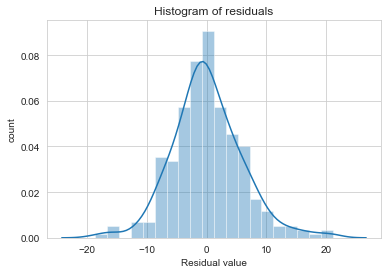

In [33]:
def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    
hist_resids(y_test, y_score)   

In [34]:
print(y_test[14])
print(y_score[14])
start = indx[1][14] -1
print(combined[start:indx[1][14]])

51
44.37961271472393
       CustomerID Title FirstName MiddleName LastName Suffix  \
10653       14328   NaN    Andrea          L   Rogers    NaN   

           AddressLine1 AddressLine2     City StateProvinceName ...   \
10653  9669 Cynthia Dr.          NaN  Shawnee  British Columbia ...    

           Occupation Gender MaritalStatus HomeOwnerFlag NumberCarsOwned  \
10653  Skilled Manual      F             S             0               2   

      NumberChildrenAtHome TotalChildren YearlyIncome  AveMonthSpend  Age  
10653                    0             0        51443             43   21  

[1 rows x 25 columns]


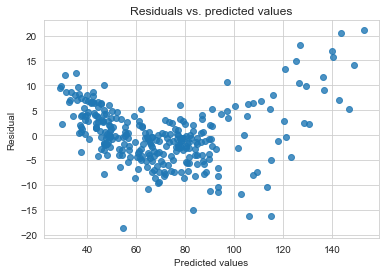

In [35]:
def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    plt.show()
resid_plot(y_test, y_score)

Residual vs predicted values does not look great, there seems to be a pattern for lower AveMonthSpend even if residuals are of deceptively normal distribution. This signals that the model might not generalize well. The RMSE is also not great.

In [36]:
# trying polynomial regression 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

poly_model = make_pipeline(PolynomialFeatures(4),
                           linear_model.LinearRegression())
poly_model.fit(X_train,y_train)
scores = poly_model.predict(X_test) 
print_metrics(y_test, scores, 14) 

Mean Square Error      = 8.10706623390317
Root Mean Square Error = 2.8472910342820894
Mean Absolute Error    = 2.3027580769856772
Median Absolute Error  = 2.056995391845703
R^2                    = 0.9887180920498432
Adjusted R^2           = 0.9882052780521088


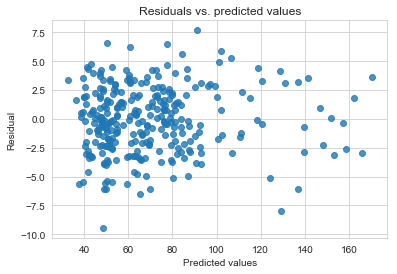

In [37]:
resid_plot(y_test, scores)

c:\users\awuah\envs\py1\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


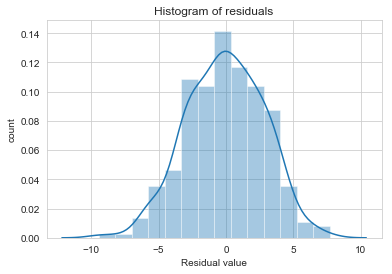

In [38]:
hist_resids(y_test, scores)   

In [39]:
print(y_test)
print(scores)

[ 88  47  47 101  79  47  74  76  32  49  44  65  61  48  51  76  64  51
  99  58  54  51  51  86 121  49 148 137  55  40  56  77  61  68  77  57
  48 164  48 112  37  90  46  90  69  57  74  61  52  99  87  75  39 102
  63  48  76  54  77  60  70  48  59 103 163  64  82  59  46  50  90  71
  55  57  62  43  45  49  59  50  70  77  85  43  77  66  56  43  47  60
  66  49  40  39  64 146  46  45  63  82  81  49  74  59  45  81  48 109
  48  72  66  67  82 150 114  64  55  49  39  79  75  85  81  50  83  67
  80  45 174  52  66  51 133  51  89  45  47 145  39  49  57  72  80  78
 120  78  80  57  80  79  51 131  90  91  45  71  44  42  41  43  43  51
  92  40  59 118  52  75  82  50  63  83  49  50  93  77  46  39  54  64
  78  36  39  83  68  72  53  49  47  64  67 123  71  67  47  83  70  84
  58  87  49  44  43  64  76  75  78 106  76  99  63  59  42  81  45  67
  75  52  57  56  91  42  44  38 134  52  38  38  45 152 100  57  48  64
  58  77  79 157  84  53  73  82  51  64  51  76 10

Using polynomial features performs much better than linear regression. The RMSE is down by an order of a magnitude. The R2 and Adjusted R2 signify a good residual distribution as evidenced on the residual scatter plot and histogram.

In [40]:
# trying Neural network 
from sklearn.neural_network import MLPRegressor
regressor = MLPRegressor(hidden_layer_sizes=(100,),  
                                    activation='logistic',
                                       learning_rate='adaptive',
                                       max_iter=1000,
                                       learning_rate_init=0.001)
regressor.fit(X_train,y_train)
scores = regressor.predict(X_test)
print_metrics(y_test, scores, 14) 

Mean Square Error      = 8.443100779005356
Root Mean Square Error = 2.9057014263350176
Mean Absolute Error    = 2.3605801896731404
Median Absolute Error  = 2.1999695994169848
R^2                    = 0.9882504616276244
Adjusted R^2           = 0.9877163917016073


In [41]:
# trying Random Forest
from sklearn.ensemble import RandomForestRegressor
rand_regressor = RandomForestRegressor(n_estimators=40)
rand_regressor.fit(X_train, y_train)
scores = rand_regressor.predict(X_test)
print_metrics(y_test, scores, 14) 

c:\users\awuah\envs\py1\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Mean Square Error      = 11.541283333333329
Root Mean Square Error = 3.3972464340011204
Mean Absolute Error    = 2.7429999999999994
Median Absolute Error  = 2.437499999999993
R^2                    = 0.9839389869976853
Adjusted R^2           = 0.9832089409521256


Random forest even if better in RMSE than LinearRegression the RandomForestR

In [42]:
# test on final test data
# import final test data
final = pd.read_csv('data/AW_test.csv')
print(final.shape)
print(final.CustomerID.unique().shape)

(500, 23)
(500,)


In [43]:
final['Age'] = generate_age(final,'%m/%d/%Y')
final[['Age','BirthDate']].head()

,Age,BirthDate
0,53,1/5/1945
1,33,10/4/1964
2,64,1/12/1934
3,39,9/22/1958
4,32,3/19/1965


In [44]:
encoded = encode_cat_features(final)
encoded[:,:]

array([[0., 1., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [45]:
numeric_final_features = np.array(final[['Age','YearlyIncome', 'NumberChildrenAtHome']])
numeric_final_features[:1,:]

array([[   53, 86931,     0]], dtype=int64)

In [46]:
final_test = np.concatenate([encoded,numeric_final_features], 1)
final_test[:,11:13]= scaler.transform(final_test[:,11:13])
final_test[:3,:14]

array([[ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  1.        ,  1.        ,
         0.        ,  1.55943317,  0.2203181 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
         1.        , -0.22014298,  0.55239847,  2.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  2.53820005,  0.64955098,  0.        ]])

In [47]:
final_reg_scores = rand_regressor.predict(final_test)
np.savetxt('final_regression_answers.csv', final_reg_scores, delimiter=',',fmt='%i')